In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = np.load("/content/drive/MyDrive/data sem thesis abhishek/normalised_data/X_datagen_allcomb_foreign_class_fixed_more_latest_normalised.npy")
X.shape

(180000, 1000)

In [ ]:
y = np.load("/content/drive/MyDrive/data sem thesis abhishek/normalised_data/y_datagen_allcomb_foreign_hotencoding_fixed_more_latest_normalised.npy")
y.shape

(180000, 5)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle = True, random_state = 34)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Flatten, Dense

In [ ]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.channels = channels
        self.reduction_ratio = reduction_ratio
        self.avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.fc1 = tf.keras.layers.Dense(channels // reduction_ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(channels, activation='sigmoid')

    def call(self, x):
        x_se = self.avg_pool(x)
        x_se = self.fc1(x_se)
        x_se = self.fc2(x_se)
        x_se = tf.reshape(x_se, [-1, 1, self.channels])
        x = x * x_se
        return x

    
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Layers
        self.conv1 = tf.keras.layers.Conv1D(out_channels, kernel_size=5,
                                            strides=stride, padding='same',
                                            dilation_rate=1, use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.se = SEBlock(out_channels)
        self.conv2 = tf.keras.layers.Conv1D(out_channels, kernel_size=5,
                                            strides=1, padding='same',
                                            dilation_rate=1, use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.shortcut = tf.keras.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = tf.keras.Sequential([
                tf.keras.layers.Conv1D(out_channels, kernel_size=1,
                                        strides=stride, use_bias=False),
                tf.keras.layers.BatchNormalization()
            ])

    def call(self, x):
        out = tf.nn.relu(self.bn1(self.conv1(x)))
        out = self.se(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = tf.nn.relu(out)
        return out


class ResNet(tf.keras.Model):
    def __init__(self, hidden_sizes, num_blocks, input_dim=1000,
                 in_channels=64, n_classes=5):
        super(ResNet, self).__init__()
        assert len(num_blocks) == len(hidden_sizes)
        self.input_dim = input_dim
        self.in_channels = in_channels
        self.n_classes = n_classes
        
        self.conv1 = tf.keras.layers.Conv1D(in_channels, kernel_size=5,
                                            strides=1, padding='same',
                                            use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        # Flexible number of residual encoding layers
        layers = []
        strides = [1] + [2] * (len(hidden_sizes) - 1)
        for idx, hidden_size in enumerate(hidden_sizes):
            layers.append(self._make_layer(hidden_size, num_blocks[idx],
                                            stride=strides[idx]))
        self.encoder = tf.keras.Sequential(layers)

        self.global_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.z_dim = self._get_encoding_size()
        self.linear = tf.keras.layers.Dense(n_classes, activation='sigmoid')


    def encode(self, x):
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        x = self.encoder(x)
        x = self.global_pooling(x)
        return x

    def call(self, x):
        z = self.encode(x)
        logits = self.linear(z)
        return logits


    def _make_layer(self, out_channels, num_blocks, stride=1):
        strides = [stride] + [1] * (num_blocks - 1)
        blocks = []
        for stride in strides:
            blocks.append(ResidualBlock(self.in_channels, out_channels,
                                            stride=stride))
            blocks.append(SEBlock(out_channels))
            self.in_channels = out_channels
        return tf.keras.Sequential(blocks)


    def _get_encoding_size(self):
        """
        Returns the dimension of the encoded input.
        """
        temp = tf.random.normal((1, self.input_dim, 1))
        z = self.encode(temp)
        z_dim = z.shape[1]
        return z_dim

In [ ]:
def create_model():
    layers = 3
    hidden_size = 50
    block_size = 2
    hidden_sizes = [hidden_size] * layers
    num_blocks = [block_size] * layers
    input_dim = 1000
    in_channels = 64
    model = ResNet(hidden_sizes, num_blocks, input_dim, in_channels, n_classes=1)
    model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
    model.build(input_shape=(None, input_dim, 1))
    return model

In [ ]:
model = create_model()
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             multiple                  320       
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 sequential_12 (Sequential)  (None, 250, 50)           168936    
                                                                 
 global_average_pooling1d_12  multiple                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_24 (Dense)            multiple                  51        
                                                                 
Total params: 169,563
Trainable params: 167,935
Non-trainab

In [ ]:
import pickle

In [ ]:
history = model.fit(X_train.reshape(-1, 1000, 1),y_train[:,0],epochs = 30, validation_data = (X_test.reshape(-1,1000,1),y_test[:,0]))
filepath = '/content/drive/MyDrive/data sem thesis abhishek/New_models/senet_individual_0.pkl'

pickle.dump(model, open(filepath, 'wb'))

Epoch 1/30
4219/4219 [==============================] - 214s 44ms/step - loss: 0.3685 - accuracy: 0.8372 - val_loss: 0.5174 - val_accuracy: 0.7542
Epoch 2/30
4219/4219 [==============================] - 180s 43ms/step - loss: 0.3235 - accuracy: 0.8635 - val_loss: 0.5989 - val_accuracy: 0.6962
Epoch 3/30
4219/4219 [==============================] - 179s 42ms/step - loss: 0.3099 - accuracy: 0.8707 - val_loss: 0.3056 - val_accuracy: 0.8716
Epoch 4/30
4219/4219 [==============================] - 187s 44ms/step - loss: 0.2998 - accuracy: 0.8756 - val_loss: 0.3586 - val_accuracy: 0.8455
Epoch 5/30
4219/4219 [==============================] - 179s 42ms/step - loss: 0.2942 - accuracy: 0.8784 - val_loss: 0.2957 - val_accuracy: 0.8803
Epoch 6/30
4219/4219 [==============================] - 187s 44ms/step - loss: 0.2895 - accuracy: 0.8807 - val_loss: 0.2860 - val_accuracy: 0.8830
Epoch 7/30
4219/4219 [==============================] - 186s 44ms/step - loss: 0.2851 - accuracy: 0.8839 - val_loss: 0

In [ ]:
np.save('/content/drive/MyDrive/data sem thesis abhishek/normalised_data/senet_individual_history_0.npy',history.history)

In [ ]:
import matplotlib.pyplot as plt

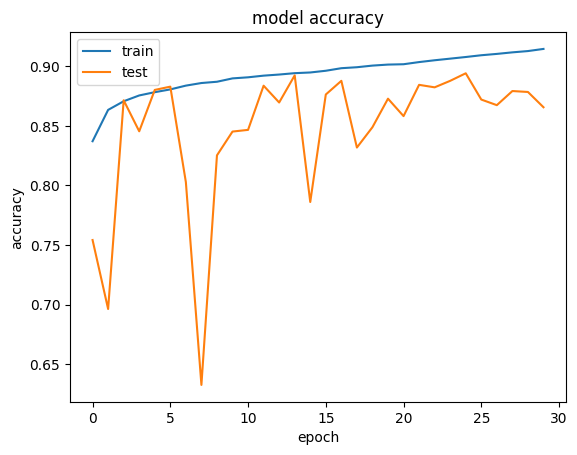

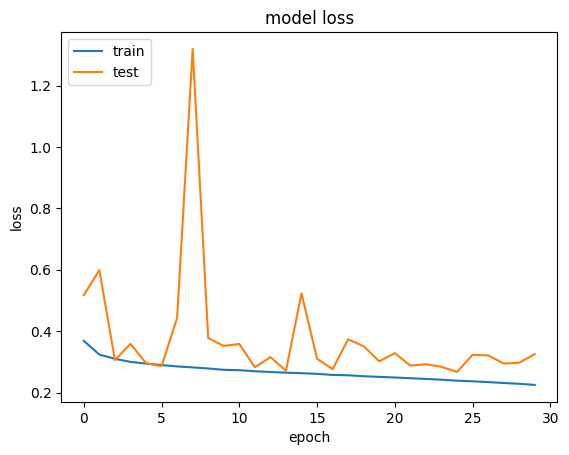

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = create_model()

In [ ]:
history = model.fit(X_train.reshape(-1, 1000, 1),y_train[:,1],epochs = 30, validation_data = (X_test.reshape(-1,1000,1),y_test[:,1]))
filepath = '/content/drive/MyDrive/data sem thesis abhishek/New_models/senet_individual_1.pkl'

pickle.dump(model, open(filepath, 'wb'))

Epoch 1/30
4219/4219 [==============================] - 206s 44ms/step - loss: 0.3037 - accuracy: 0.8763 - val_loss: 0.2917 - val_accuracy: 0.8849
Epoch 2/30
4219/4219 [==============================] - 185s 44ms/step - loss: 0.2490 - accuracy: 0.9052 - val_loss: 0.2461 - val_accuracy: 0.9041
Epoch 3/30
4219/4219 [==============================] - 188s 45ms/step - loss: 0.2313 - accuracy: 0.9145 - val_loss: 0.2621 - val_accuracy: 0.8996
Epoch 4/30
4219/4219 [==============================] - 187s 44ms/step - loss: 0.2227 - accuracy: 0.9186 - val_loss: 0.2684 - val_accuracy: 0.8943
Epoch 5/30
4219/4219 [==============================] - 189s 45ms/step - loss: 0.2163 - accuracy: 0.9222 - val_loss: 0.2316 - val_accuracy: 0.9142
Epoch 6/30
4219/4219 [==============================] - 186s 44ms/step - loss: 0.2131 - accuracy: 0.9232 - val_loss: 0.2423 - val_accuracy: 0.9090
Epoch 7/30
4219/4219 [==============================] - 187s 44ms/step - loss: 0.2103 - accuracy: 0.9250 - val_loss: 0

In [ ]:
np.save('/content/drive/MyDrive/data sem thesis abhishek/normalised_data/senet_individual_history_1.npy',history.history)

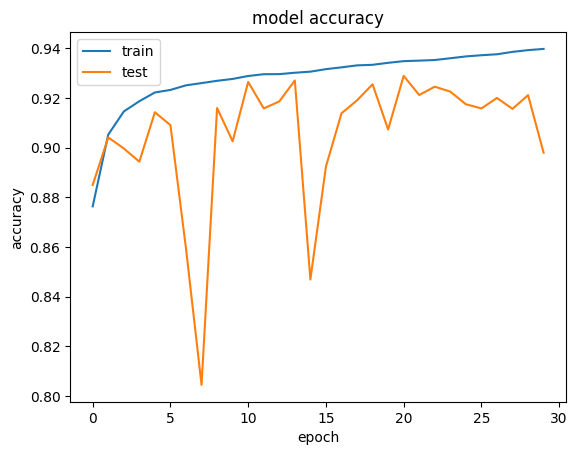

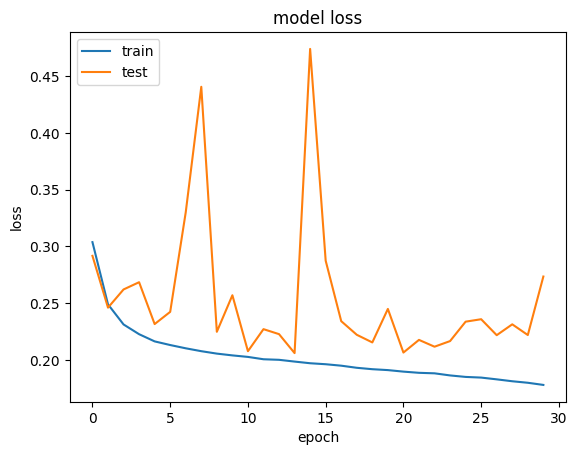

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()